In [1]:
import numpy as np 
import cv2
from PIL import Image
import matplotlib.pyplot as plt 
import os
import torch
import torch.nn as nn
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor
import torchvision.transforms as T 
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop,Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device='cuda:3' if torch.cuda.is_available() else 'cpu'
device


'cuda:3'

데이터 불러오기

Files already downloaded and verified
Files already downloaded and verified


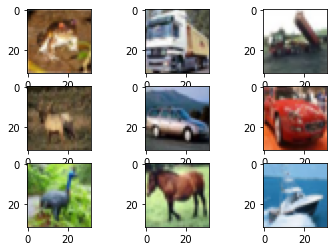

In [2]:
training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data=CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=ToTensor()
)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(training_data.data[i])
plt.show()

데이터 증강

Files already downloaded and verified
Files already downloaded and verified


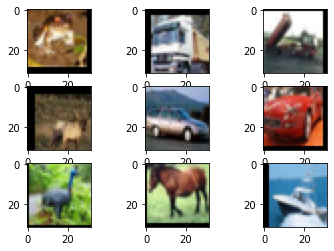

In [3]:
transforms=Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
])

training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=transforms
)
test_data=CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.show()


데이터 정규화

Files already downloaded and verified
Files already downloaded and verified


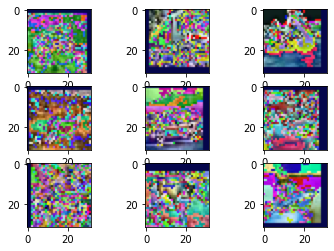

In [4]:
transforms=Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    
    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247,0.243,0.261)),
    T.ToPILImage()
])

training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=transforms
)
test_data=CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.show()

데이터셋의 평균과 표준편차

In [5]:
training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=ToTensor()
)

imgs=[item[0] for item in training_data]
imgs= torch.stack(imgs,dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


BasicBlock

In [6]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_dim):
        super(BasicBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,hidden_dim,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(hidden_dim,out_channels,kernel_size=3,padding=1)
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)
        
        return x
    

CNN 모델 정의

In [7]:
class CNN(nn.Module):
    def __init__(self,num_class):
        super(CNN,self).__init__()
        self.block1=BasicBlock(in_channels=3,out_channels=32,hidden_dim=16)
        self.block2=BasicBlock(in_channels=32,out_channels=128,hidden_dim=64)
        self.block3=BasicBlock(in_channels=128,out_channels=256,hidden_dim=128)
        
        self.fc1=nn.Linear(in_features=4096,out_features=2048)
        self.fc2=nn.Linear(in_features=2048,out_features=256)
        self.fc3=nn.Linear(in_features=256,out_features=num_class)
        
        self.relu=nn.ReLU()
        
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=torch.flatten(x,start_dim=1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        
        return x

In [44]:
from torchvision.transforms import Resize,RandomHorizontalFlip,RandomCrop
transforms=Compose([
    Resize(224),
    RandomCrop((224,224),padding=0.4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247,0.243,0.261)),
])

training_data=CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=transforms
)
test_data=CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=transforms
)

train_loader=DataLoader(training_data,batch_size=2048,shuffle=True)
test_loader=DataLoader(test_data,batch_size=2048,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [45]:
from torchvision.models.vgg import vgg16

model=vgg16(pretrained=True)
fc=nn.Sequential(
    nn.Linear(512*7*7,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,10)
)
model.classifier=fc
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
lr=1e-4
import tqdm
optim=Adam(model.parameters(),lr=lr)

for epoch in range(30):
    iterator =tqdm.tqdm(train_loader)
    for data,label in iterator:
        optim.zero_grad()
        preds=model(data.to(device))
        loss=nn.CrossEntropyLoss()(preds,label.to(device))
        loss.backward()
        optim.step()
        iterator.set_description(f"epoch : {epoch+1} loss: {loss.item()}")
torch.save(model.state_dict(),"../model/CIFAR.pth")

  0%|          | 0/25 [00:00<?, ?it/s]


TypeError: integer argument expected, got float

In [49]:
tqdm.tqdm(train_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

In [34]:
model.load_state_dict(torch.load("../model/CIFAR.pth",map_location=device))
num_corr=0
with torch.no_grad():
    for data,label in test_loader:
        output=model(data.to(device))
        preds=output.data.max(1)[1]
        corr=preds.eq(label.to(device).data).sum().item()
        num_corr+=corr

    print(f"Accuracy:{num_corr/len(test_data)}")

Accuracy:0.0993


In [35]:
preds

tensor([6, 2, 2,  ..., 6, 2, 2], device='cuda:3')